## Assignment 01 - Addition Two Numbers

A brief summary to the problem:

> Given two numbers $x$ and $y$ with a range from 0 to 100, use deep learning to predict the $z$, the result of adding $x$ and $y$ using classification method

With $x = [0\ldotp\ldotp 100]$ and $y = [0\ldotp\ldotp 100]$, the minimum value of $z$ is **0** and the maximum value is **200**. Therefore, there are **200** number of classes.

To make the problem challenging, we need to take out some integers from the possible value in both $x$ and $y$ lists, for example **28, 51, 73**, from the training data. And use them later in the prediction. The idea is to test if the *trained network* can generalize well to the unseen dataset.

Below is the code, starting with the import parts

In [10]:
import numpy as np
import keras

from keras.layers import *
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import LearningRateScheduler
import keras.backend as K
import tensorflow as tf

from random import shuffle
from time import time

In [11]:
print(keras.__version__)
print(tf.__version__)

2.0.8
1.3.0


In [12]:
max_range1, max_range2 = 100, 100 # the maximum value of x and y
test_list = [28, 51, 73] # the list of the numbers to be taken out from the training data

In [13]:
n_classes = max_range1 + max_range2 + 1 # output class
num_data = 500000 # number of training data

#### We generate the training data using random number generator

In [14]:
def gen_random_data(seed = 8):
    z = []    
    seed = 8
    np.random.seed(seed)
    t = [] # validation data
    for i in range(0,num_data):
        v1 = np.random.randint(0,max_range1+1)
        v2 = np.random.randint(0,max_range2+1)
        if v1 in test_list or v2 in test_list:
            t.append((v1,v2,v1+v2))
            continue
        z.append((v1,v2,v1+v2))
    z = z + t
    return z

In [15]:
z = gen_random_data()

# set the dataset as numpy array
x=np.array( [v[0:2] for v in z] ).astype('float32')
y=np.array( [v[2:][0] for v in z] ).astype('float32')

#### We need to normalize the training data to be within the range of $[0,1]$

In [16]:
# normalize
x = x / max_range1

In [17]:
# hot encoding
yy=to_categorical(y, n_classes)

#### We set 80$\%$ for training data and 20$\%$ for validation data 

In [18]:
# split train and validation data
n_train = int( 0.8 * num_data ) 
x_train = x[0:n_train,]
x_test = x[n_train:,]
y_train = yy[0:n_train,] 
y_test = yy[n_train:,]


#### Set the hyperparameters:

In [19]:
# setup hyperparameter for dense layer
n_input = 2 # x + y -- two input dataset
n_hidden_1 = 200 # layer - 1
n_hidden_2 = 150 # layer - 2
n_hidden_3 = 100 # layer - 3
n_hidden_4 = 50 # layer - 3

#### The model

In [20]:
Inp = Input(shape=(2,))
x = Dense( n_hidden_1, activation = 'relu', name = 'Dense_1')(Inp)
x = Dense( n_hidden_2, activation = 'relu', name = 'Dense_2')(x)
x = Dense( n_hidden_3, activation = 'relu', name = 'Dense_3')(x)
x = Dense( n_hidden_4, activation = 'relu', name = 'Dense_4')(x)
output = Dense( n_classes, activation = 'softmax', name = 'Dense_out')(x)

In [21]:
# create the model
model = Model(Inp, output)

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
Dense_1 (Dense)              (None, 200)               600       
_________________________________________________________________
Dense_2 (Dense)              (None, 150)               30150     
_________________________________________________________________
Dense_3 (Dense)              (None, 100)               15100     
_________________________________________________________________
Dense_4 (Dense)              (None, 50)                5050      
_________________________________________________________________
Dense_out (Dense)            (None, 201)               10251     
Total params: 61,151
Trainable params: 61,151
Non-trainable params: 0
_________________________________________________________________


In [23]:
train_epochs = 400
batch_sizes = 40000

We introduce a function to allow changing the learning rate at different stage of epochs

In [24]:
def step_decay(epoch):
    if epoch<20:
        return 0.002
    if epoch<60:
        return 0.001
    return 0.0005

lrate=LearningRateScheduler(step_decay)

In [25]:
adam = keras.optimizers.Adam()
model.compile( loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'] )

#### Train the model

In [26]:
history = model.fit(x_train, y_train, 
                    batch_size = batch_sizes, 
                    epochs = train_epochs, verbose = 1, 
                    validation_data=(x_test, y_test), 
                    callbacks=[lrate])

Train on 400000 samples, validate on 100000 samples
Epoch 1/400
400000/400000 [==============================] - 4s - loss: 5.2740 - acc: 0.0081 - val_loss: 5.1965 - val_acc: 0.0094
Epoch 2/400
400000/400000 [==============================] - 2s - loss: 5.1532 - acc: 0.0092 - val_loss: 5.0674 - val_acc: 0.0091
Epoch 3/400
400000/400000 [==============================] - 2s - loss: 5.0373 - acc: 0.0090 - val_loss: 4.9424 - val_acc: 0.0113
Epoch 4/400
400000/400000 [==============================] - 2s - loss: 4.8722 - acc: 0.0108 - val_loss: 4.6889 - val_acc: 0.0162
Epoch 5/400
400000/400000 [==============================] - 2s - loss: 4.4886 - acc: 0.0289 - val_loss: 4.1501 - val_acc: 0.0332
Epoch 6/400
400000/400000 [==============================] - 2s - loss: 3.9447 - acc: 0.0557 - val_loss: 3.6487 - val_acc: 0.0884
Epoch 7/400
400000/400000 [==============================] - 2s - loss: 3.5279 - acc: 0.0913 - val_loss: 3.3115 - val_acc: 0.1229
Epoch 8/400
400000/400000 [===========

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt 

In [28]:
def plot_train(hist):
    h = hist.history
    if 'acc' in h:
        meas='acc'
        loc='lower right'
    else:
        meas='loss'
        loc='upper right'
    plt.plot(hist.history[meas])
    plt.plot(hist.history['val_'+meas])
    plt.title('model '+meas)
    plt.ylabel(meas)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc=loc)

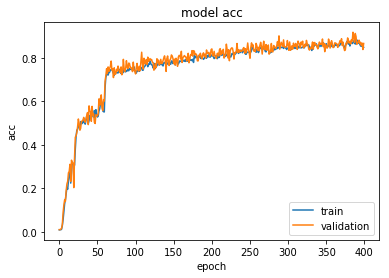

In [29]:
plot_train(history)

#### Evaluate the model

In [30]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.56541998786
Test accuracy: 0.86727


#### Save the model

In [31]:
model.save('model.h5') 

#### Do prediction test on random data

In [32]:
rr = []
numtest = 1000
for i in range(0,numtest):
    v3 = np.random.randint(0, max_range1)
    v4 = np.random.randint(0, max_range2)
    v6 = np.array([[v3,v4]]).astype('float32') / max_range1    
    v5=np.argmax( model.predict( v6 ) )
    r = v5==(v3+v4)
    rr.append(r)

print("% prediction accuracy 1 - ", rr.count(True) / numtest * 100)

% prediction accuracy 1 -  87.9


The prediction accuracy from random dataset: **87.9$\%$**

In [33]:
rr = []
for i in range(0,101):
    for j in test_list:
        v3 = np.random.randint(0, max_range1)
        v4 = j
        v6 = np.array([[v3,v4]]).astype('float32') / max_range1    
        v5=np.argmax( model.predict( v6 ) )
        r = v5==(v3+v4)
        rr.append(r)
        
        # swap v3 and v4 with test list
        v3 = j
        v4 = np.random.randint(0, max_range1)
        v6 = np.array([[v3,v4]]).astype('float32') / max_range1    
        v5=np.argmax( model.predict( v6 ) )
        r = v5==(v3+v4)
        rr.append(r)

print("% prediction accuracy 2 - {0:2.2f}".format(rr.count(True) / len(rr) * 100))

% prediction accuracy 2 - 88.12


The prediction accuracy from test list dataset: **88.12$\%$**

To improve the accuracy in this case, I have tried to increase the number of training epochs, and can get higher prediction accuracy